## Data Prep

In [30]:
pip install prophet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [31]:
%matplotlib inline
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import logging
import warnings
from sklearn.metrics import mean_squared_error

logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('numexpr').setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [32]:
data_clean = pd.read_csv('data_clean.csv')
data_clean = data_clean[['date', 'new_cases','location']]
data_clean['date'] = pd.to_datetime(data_clean['date'])
# log transform 
data_clean['new_cases_log'] = np.log(data_clean['new_cases'])
data_clean.head()

,date,new_cases,location,new_cases_log
0,2020-03-21,713.0,Belgium,6.569481
1,2020-03-22,662.0,Belgium,6.495266
2,2020-03-23,469.0,Belgium,6.150603
3,2020-03-24,486.0,Belgium,6.186209
4,2020-03-25,1328.0,Belgium,7.191429


In [33]:
data_clean['new_cases_log'].describe()
inf_count = np.isinf(data_clean['new_cases_log']).sum()
print(f"Number of '-inf' values: {inf_count}")
data_clean['new_cases_log'] = data_clean['new_cases_log'].replace(-np.inf, 0)

Number of '-inf' values: 5


In [34]:
# account for lockdowns
from prophet.make_holidays import make_holidays_df
# Belgium 
belgium_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-20', 'lower_window': 0, 'ds_upper': '2020-05-13'},
    {'holiday': 'lockdown_2', 'ds': '2020-10-06', 'lower_window': 0, 'ds_upper': '2021-04-26'}
])
for t_col in ['ds', 'ds_upper']:
    belgium_lockdowns[t_col] = pd.to_datetime(belgium_lockdowns[t_col])
belgium_lockdowns['upper_window'] = (belgium_lockdowns['ds_upper'] - belgium_lockdowns['ds']).dt.days
belgium_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='Belgium')
holiday_belgium = pd.concat((belgium_lockdowns, belgium_holidays))
holiday_belgium = holiday_belgium.reset_index(drop=True)
holiday_belgium.loc[2:, 'ds_upper'] = holiday_belgium.loc[2:, 'ds'] + pd.Timedelta(days=7)

# Denmark 
denmark_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-13', 'lower_window': 0, 'ds_upper': '2020-04-15'}
])
for t_col in ['ds', 'ds_upper']:
    denmark_lockdowns[t_col] = pd.to_datetime(denmark_lockdowns[t_col])
denmark_lockdowns['upper_window'] = (denmark_lockdowns['ds_upper'] - denmark_lockdowns['ds']).dt.days
denmark_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='Denmark')
holiday_denmark = pd.concat((denmark_lockdowns, denmark_holidays))
holiday_denmark = holiday_denmark.reset_index(drop=True)
holiday_denmark.loc[2:, 'ds_upper'] = holiday_denmark.loc[2:, 'ds'] + pd.Timedelta(days=7)

# Finland
finland_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-16', 'lower_window': 0, 'ds_upper': '2020-05-13'},
    {'holiday': 'lockdown_2', 'ds': '2021-03-08', 'lower_window': 0, 'ds_upper': '2021-03-30'}
])
for t_col in ['ds', 'ds_upper']:
    finland_lockdowns[t_col] = pd.to_datetime(finland_lockdowns[t_col])
finland_lockdowns['upper_window'] = (finland_lockdowns['ds_upper'] - finland_lockdowns['ds']).dt.days
finland_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='Finland')
holiday_finland = pd.concat((finland_lockdowns, finland_holidays))
holiday_finland = holiday_finland.reset_index(drop=True)
holiday_finland.loc[2:, 'ds_upper'] = holiday_finland.loc[2:, 'ds'] + pd.Timedelta(days=7)

# Ireland
ireland_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-13', 'lower_window': 0, 'ds_upper': '2020-05-18'},
    {'holiday': 'lockdown_2', 'ds': '2021-01-26', 'lower_window': 0, 'ds_upper': '2021-03-19'}
])
for t_col in ['ds', 'ds_upper']:
    ireland_lockdowns[t_col] = pd.to_datetime(ireland_lockdowns[t_col])
ireland_lockdowns['upper_window'] = (ireland_lockdowns['ds_upper'] - ireland_lockdowns['ds']).dt.days
ireland_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='Ireland')
holiday_ireland = pd.concat((ireland_lockdowns, ireland_holidays))
holiday_ireland = holiday_ireland.reset_index(drop=True)
holiday_ireland.loc[2:, 'ds_upper'] = holiday_ireland.loc[2:, 'ds'] + pd.Timedelta(days=7)

# Italy
italy_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-08', 'lower_window': 0, 'ds_upper': '2020-05-04'},
    {'holiday': 'lockdown_2', 'ds': '2020-11-04', 'lower_window': 0, 'ds_upper': '2021-01-06'}
])
for t_col in ['ds', 'ds_upper']:
    italy_lockdowns[t_col] = pd.to_datetime(italy_lockdowns[t_col])
italy_lockdowns['upper_window'] = (italy_lockdowns['ds_upper'] - italy_lockdowns['ds']).dt.days
italy_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='Italy')
holiday_italy = pd.concat((italy_lockdowns, italy_holidays))
holiday_italy = holiday_italy.reset_index(drop=True)
holiday_italy.loc[2:, 'ds_upper'] = holiday_italy.loc[2:, 'ds'] + pd.Timedelta(days=7)

# Lithuania
lithuania_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-12', 'lower_window': 0, 'ds_upper': '2020-04-16'},
    {'holiday': 'lockdown_2', 'ds': '2020-11-07', 'lower_window': 0, 'ds_upper': '2021-12-31'}
])
for t_col in ['ds', 'ds_upper']:
    lithuania_lockdowns[t_col] = pd.to_datetime(lithuania_lockdowns[t_col])
lithuania_lockdowns['upper_window'] = (lithuania_lockdowns['ds_upper'] - lithuania_lockdowns['ds']).dt.days
lithuania_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='Lithuania')
holiday_lithuania = pd.concat((lithuania_lockdowns, lithuania_holidays))
holiday_lithuania = holiday_lithuania.reset_index(drop=True)
holiday_lithuania.loc[2:, 'ds_upper'] = holiday_lithuania.loc[2:, 'ds'] + pd.Timedelta(days=7)

# Norway
norway_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-12', 'lower_window': 0, 'ds_upper': '2020-05-08'}
])
for t_col in ['ds', 'ds_upper']:
    norway_lockdowns[t_col] = pd.to_datetime(norway_lockdowns[t_col])
norway_lockdowns['upper_window'] = (norway_lockdowns['ds_upper'] - norway_lockdowns['ds']).dt.days
norway_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='Norway')
holiday_norway = pd.concat((norway_lockdowns, norway_holidays))
holiday_norway = holiday_norway.reset_index(drop=True)
holiday_norway.loc[2:, 'ds_upper'] = holiday_norway.loc[2:, 'ds'] + pd.Timedelta(days=7)

# Poland
poland_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-19', 'lower_window': 0, 'ds_upper': '2020-06-25'},
    {'holiday': 'lockdown_2', 'ds': '2020-12-28', 'lower_window': 0, 'ds_upper': '2021-01-31'},
    {'holiday': 'lockdown_3', 'ds': '2021-03-11', 'lower_window': 0, 'ds_upper': '2021-04-28'}
])
for t_col in ['ds', 'ds_upper']:
    poland_lockdowns[t_col] = pd.to_datetime(poland_lockdowns[t_col])
poland_lockdowns['upper_window'] = (poland_lockdowns['ds_upper'] - poland_lockdowns['ds']).dt.days
poland_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='Poland')
holiday_poland = pd.concat((poland_lockdowns, poland_holidays))
holiday_poland = holiday_poland.reset_index(drop=True)
holiday_poland.loc[2:, 'ds_upper'] = holiday_poland.loc[2:, 'ds'] + pd.Timedelta(days=7)

# Switzerland
swiss_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-19', 'lower_window': 0, 'ds_upper': '2020-06-25'},
    {'holiday': 'lockdown_2', 'ds': '2020-10-01', 'lower_window': 0, 'ds_upper': '2021-09-21'},
    {'holiday': 'lockdown_3', 'ds': '2021-12-01', 'lower_window': 0, 'ds_upper': '2022-02-17'}
])
for t_col in ['ds', 'ds_upper']:
    swiss_lockdowns[t_col] = pd.to_datetime(swiss_lockdowns[t_col])
swiss_lockdowns['upper_window'] = (swiss_lockdowns['ds_upper'] - swiss_lockdowns['ds']).dt.days
switzerland_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='Switzerland')
holiday_switzerland = pd.concat((swiss_lockdowns, switzerland_holidays))
holiday_switzerland = holiday_switzerland.reset_index(drop=True)
holiday_switzerland.loc[2:, 'ds_upper'] = holiday_switzerland.loc[2:, 'ds'] + pd.Timedelta(days=7)

# United Kingdom
uk_lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-16', 'lower_window': 0, 'ds_upper': '2020-06-01'},
    {'holiday': 'lockdown_2', 'ds': '2020-11-05', 'lower_window': 0, 'ds_upper': '2020-12-02'},
    {'holiday': 'lockdown_3', 'ds': '2021-01-06', 'lower_window': 0, 'ds_upper': '2022-03-08'}
])
for t_col in ['ds', 'ds_upper']:
    uk_lockdowns[t_col] = pd.to_datetime(uk_lockdowns[t_col])
uk_lockdowns['upper_window'] = (uk_lockdowns['ds_upper'] - uk_lockdowns['ds']).dt.days
uk_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='UK')
holiday_unitedkingdom = pd.concat((uk_lockdowns, uk_holidays))
holiday_unitedkingdom = holiday_unitedkingdom.reset_index(drop=True)
holiday_unitedkingdom.loc[2:, 'ds_upper'] = holiday_unitedkingdom.loc[2:, 'ds'] + pd.Timedelta(days=7)

In [35]:
data_italy = data_clean[data_clean['location'] == 'Italy']
data_italy = data_italy.drop(['location'], axis=1)
data_italy.head()

,date,new_cases,new_cases_log
4120,2020-03-21,5986.0,8.697179
4121,2020-03-22,6557.0,8.788288
4122,2020-03-23,5560.0,8.623353
4123,2020-03-24,4789.0,8.474077
4124,2020-03-25,5249.0,8.565793


In [36]:
split_date = '2023-01-01'
train_italy = data_italy[data_italy['date'] < split_date]
test_italy = data_italy[data_italy['date'] >= split_date]

## Prophet Single

### Italy Model Development

13:39:10 - cmdstanpy - INFO - Chain [1] start processing
13:39:11 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 19991.570417552495
Test RMSE: 17571.548675304613


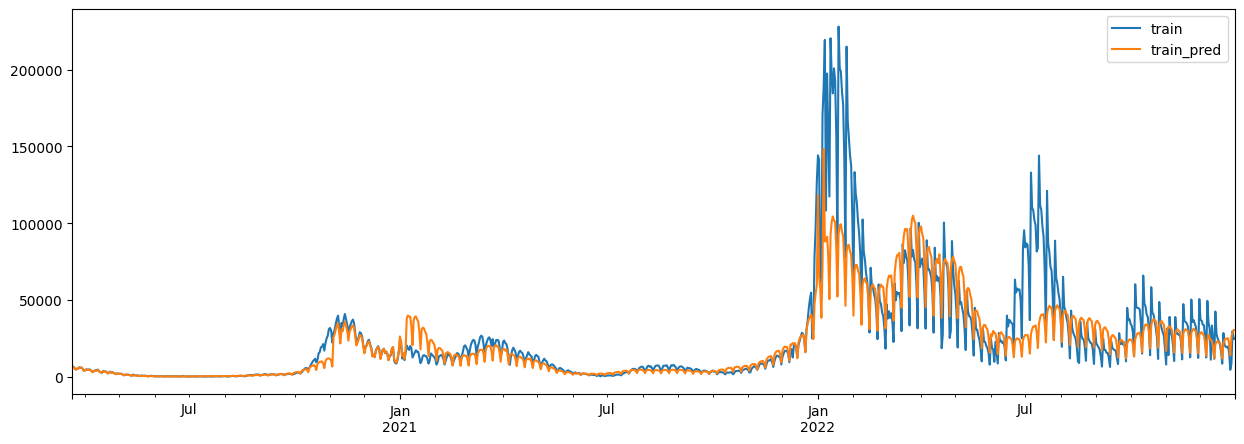

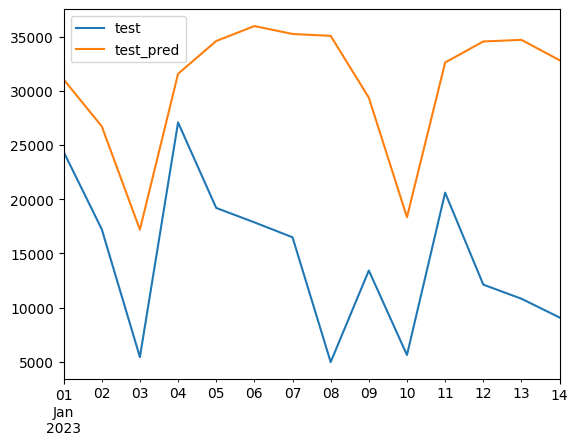

In [51]:
model_italy = Prophet(
            holidays=holiday_italy,
            holidays_prior_scale = 0.1,
            seasonality_prior_scale = 1,
            # changepoint_range=0.7, 
            changepoint_prior_scale = 0.05,
            seasonality_mode = 'additive'
             )
model_italy.fit(train_italy.rename(columns={'date':'ds', 'new_cases_log':'y'}))

train_pred=model_italy.predict(train_italy.reset_index().rename(columns={'date':'ds', 'new_cases_log':'y'})).set_index('ds')
train_pred['yhat_exp'] = np.exp(train_pred['yhat'])
pd.concat([train_italy.set_index('date')['new_cases'],train_pred['yhat_exp']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

test_pred=model_italy.predict(test_italy.reset_index().rename(columns={'date':'ds', 'new_cases_log':'y'})).set_index('ds')
test_pred['yhat_exp'] = np.exp(test_pred['yhat'])
pd.concat([test_italy.set_index('date')['new_cases'],test_pred['yhat_exp']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

train_rmse_italy = np.sqrt(mean_squared_error(train_italy['new_cases'], train_pred['yhat_exp']))
test_rmse_italy = np.sqrt(mean_squared_error(test_italy['new_cases'], test_pred['yhat_exp']))
print(f'Train RMSE: {train_rmse_italy}')
print(f'Test RMSE: {test_rmse_italy}')

### Cross Validation
https://zerotomastery.io/blog/time-series-forecasting-with-facebook-prophet/#:~:text=Cross%2Dvalidation%20is%20an%20important,on%20the%20corresponding%20testing%20set.


In [89]:
#Parameter Grid
from sklearn.model_selection import ParameterGrid
from prophet.diagnostics import cross_validation, performance_metrics
param_grid = {'seasonality_mode': ["additive", 'multiplicative'],
              'seasonality_prior_scale': [1, 5, 10, 20],
              'holidays_prior_scale': [5, 10, 20, 25],
              'changepoint_prior_scale': [0.005, 0.01, 0.05, 0.1]}
grid = ParameterGrid(param_grid)
len(list(grid))

#Store the results
rmse = []
#Loop
for params in grid:
  #model
  m = Prophet(holidays = holiday_italy,
              seasonality_mode = params['seasonality_mode'],
              seasonality_prior_scale = params['seasonality_prior_scale'],
              holidays_prior_scale = params['holidays_prior_scale'],
              changepoint_prior_scale = params['changepoint_prior_scale'])
  m.fit(train_italy.rename(columns={'date':'ds', 'new_cases_log':'y'}))

  #CV
  df_cv = cross_validation(m,
                          horizon = '14 days',
                          period = '100 days',
                          initial = '365 days',
                          parallel = 'processes')

  #Measure the error and store the result
  error = performance_metrics(df_cv)["rmse"].mean()
  rmse.append(error)

15:28:35 - cmdstanpy - INFO - Chain [1] start processing
15:28:36 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
15:28:37 - cmdstanpy - INFO - Chain [1] start processing
15:28:37 - cmdstanpy - INFO - Chain [1] start processing
15:28:37 - cmdstanpy - INFO - Chain [1] start processing
15:28:37 - cmdstanpy - INFO - Chain [1] done processing
15:28:37 - cmdstanpy - INFO - Chain [1] start processing
15:28:37 - cmdstanpy - INFO - Chain [1] done processing
15:28:37 - cmdstanpy - INFO - Chain [1] done processing
15:28:37 - cmdstanpy - INFO - Chain [1] done processing
15:28:37 - cmdstanpy - INFO -

In [90]:
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
best_params = tuning_results[tuning_results.rmse == tuning_results.rmse.min()].transpose()
best_params

,121
changepoint_prior_scale,0.1
holidays_prior_scale,25
seasonality_mode,additive
seasonality_prior_scale,5
rmse,0.600353


15:38:51 - cmdstanpy - INFO - Chain [1] start processing
15:38:51 - cmdstanpy - INFO - Chain [1] done processing


Train RMSE: 14935.357941987048
Test RMSE: 21810.985043022745


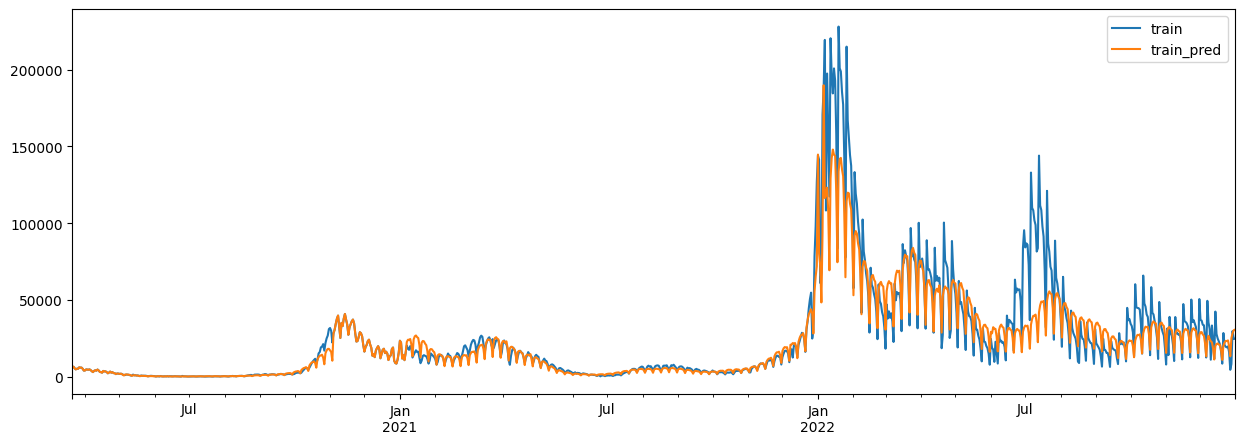

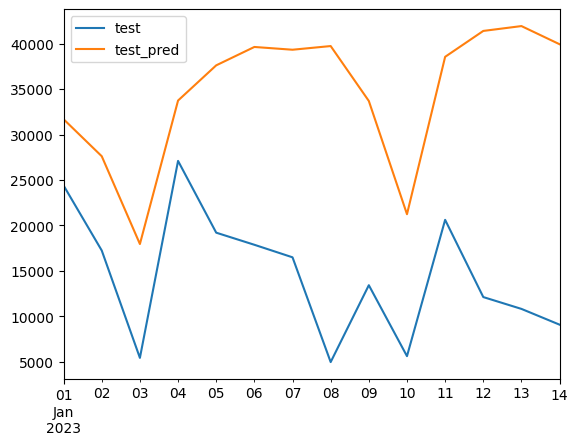

In [94]:
model_italy_cv = Prophet(
            holidays=holiday_italy,
            holidays_prior_scale = 25,
            seasonality_prior_scale = 5,
            changepoint_prior_scale = 0.1,
            seasonality_mode = 'additive'
             )
model_italy_cv.fit(train_italy.rename(columns={'date':'ds', 'new_cases_log':'y'}))

train_pred=model_italy_cv.predict(train_italy.reset_index().rename(columns={'date':'ds', 'new_cases_log':'y'})).set_index('ds')
train_pred['yhat_exp'] = np.exp(train_pred['yhat'])
pd.concat([train_italy.set_index('date')['new_cases'],train_pred['yhat_exp']], axis=1).plot(figsize=(15,5)) 
plt.legend(['train', 'train_pred'])

test_pred=model_italy_cv.predict(test_italy.reset_index().rename(columns={'date':'ds', 'new_cases_log':'y'})).set_index('ds')
test_pred['yhat_exp'] = np.exp(test_pred['yhat'])
pd.concat([test_italy.set_index('date')['new_cases'],test_pred['yhat_exp']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

train_rmse_italy = np.sqrt(mean_squared_error(train_italy['new_cases'], train_pred['yhat_exp']))
test_rmse_italy = np.sqrt(mean_squared_error(test_italy['new_cases'], test_pred['yhat_exp']))
print(f'Train RMSE: {train_rmse_italy}')
print(f'Test RMSE: {test_rmse_italy}')


### Other countries

16:58:14 - cmdstanpy - INFO - Chain [1] start processing
16:58:15 - cmdstanpy - INFO - Chain [1] done processing
16:58:15 - cmdstanpy - INFO - Chain [1] start processing


Belgium - Train RMSE: 2335.1362101170243, Test RMSE: 250.42882609258797, Test SRMSE: 42.28686003251998


16:58:15 - cmdstanpy - INFO - Chain [1] done processing
16:58:16 - cmdstanpy - INFO - Chain [1] start processing


Denmark - Train RMSE: 2832.961549272057, Test RMSE: 367.5746123157109, Test SRMSE: 62.61156554836298


16:58:16 - cmdstanpy - INFO - Chain [1] done processing
16:58:17 - cmdstanpy - INFO - Chain [1] start processing


Finland - Train RMSE: 720.2280133343136, Test RMSE: 474.2462719853175, Test SRMSE: 360.6435528405456


16:58:17 - cmdstanpy - INFO - Chain [1] done processing
16:58:17 - cmdstanpy - INFO - Chain [1] start processing


Ireland - Train RMSE: 1273.9431927878056, Test RMSE: 339.2053112361144, Test SRMSE: 75.19991064616947


16:58:17 - cmdstanpy - INFO - Chain [1] done processing


Italy - Train RMSE: 19256.132307379194, Test RMSE: 14373.949543313072, Test SRMSE: 98.45845293042724


16:58:18 - cmdstanpy - INFO - Chain [1] start processing
16:58:19 - cmdstanpy - INFO - Chain [1] done processing
16:58:19 - cmdstanpy - INFO - Chain [1] start processing


Lithuania - Train RMSE: 869.2597995873124, Test RMSE: 219.26243102483923, Test SRMSE: 74.21842442813707


16:58:19 - cmdstanpy - INFO - Chain [1] done processing


Norway - Train RMSE: 1424.938338656048, Test RMSE: 40.60232318187029, Test SRMSE: 31.405111853380337


16:58:20 - cmdstanpy - INFO - Chain [1] start processing
16:58:20 - cmdstanpy - INFO - Chain [1] done processing


Poland - Train RMSE: 4623.125780185711, Test RMSE: 196.03936945755976, Test SRMSE: 57.53776042779531


16:58:21 - cmdstanpy - INFO - Chain [1] start processing
16:58:22 - cmdstanpy - INFO - Chain [1] done processing
16:58:22 - cmdstanpy - INFO - Chain [1] start processing


Switzerland - Train RMSE: 578.6353787762547, Test RMSE: 417.4885597459912, Test SRMSE: 142.24482444497147


16:58:22 - cmdstanpy - INFO - Chain [1] done processing


United Kingdom - Train RMSE: 8437.360857831402, Test RMSE: 3719.155763777927, Test SRMSE: 91.48571650717044
                  train_rmse     test_rmse  test_srmse
Belgium          2335.136210    250.428826   42.286860
Denmark          2832.961549    367.574612   62.611566
Finland           720.228013    474.246272  360.643553
Ireland          1273.943193    339.205311   75.199911
Italy           19256.132307  14373.949543   98.458453
Lithuania         869.259800    219.262431   74.218424
Norway           1424.938339     40.602323   31.405112
Poland           4623.125780    196.039369   57.537760
Switzerland       578.635379    417.488560  142.244824
United Kingdom   8437.360858   3719.155764   91.485717


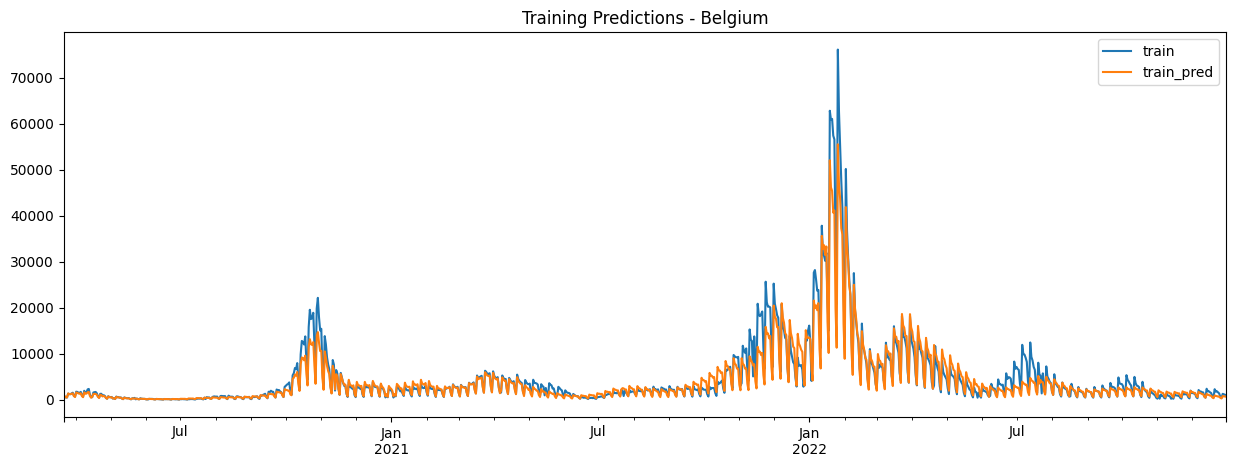

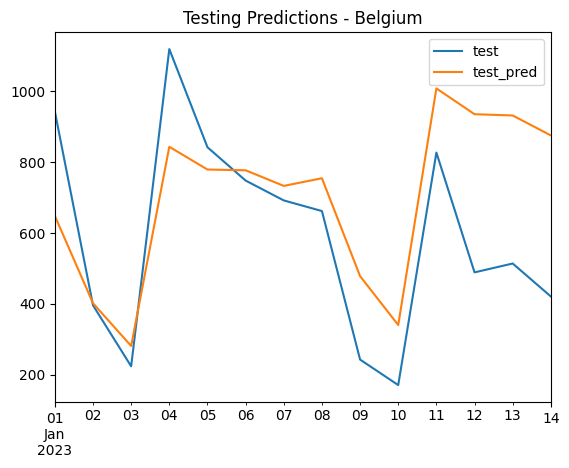

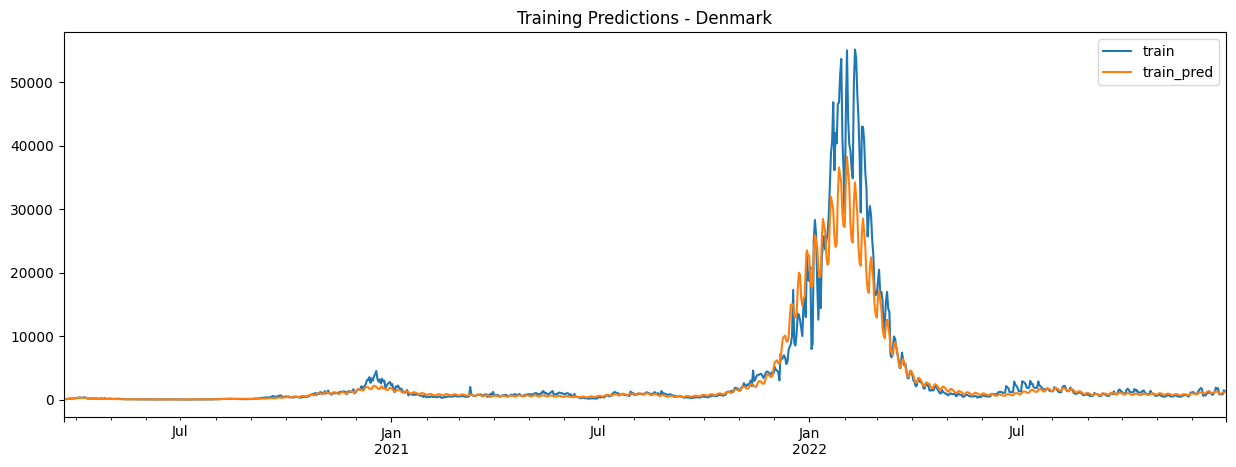

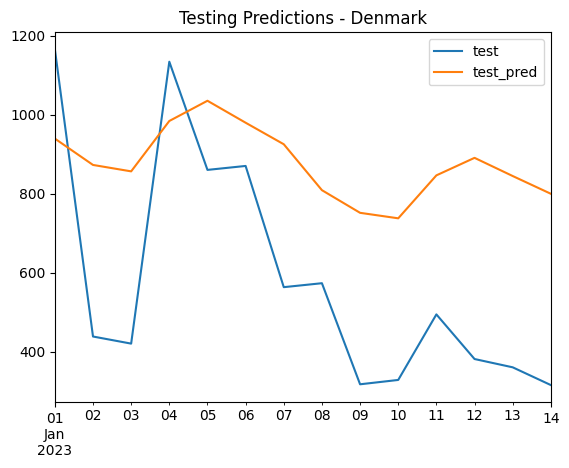

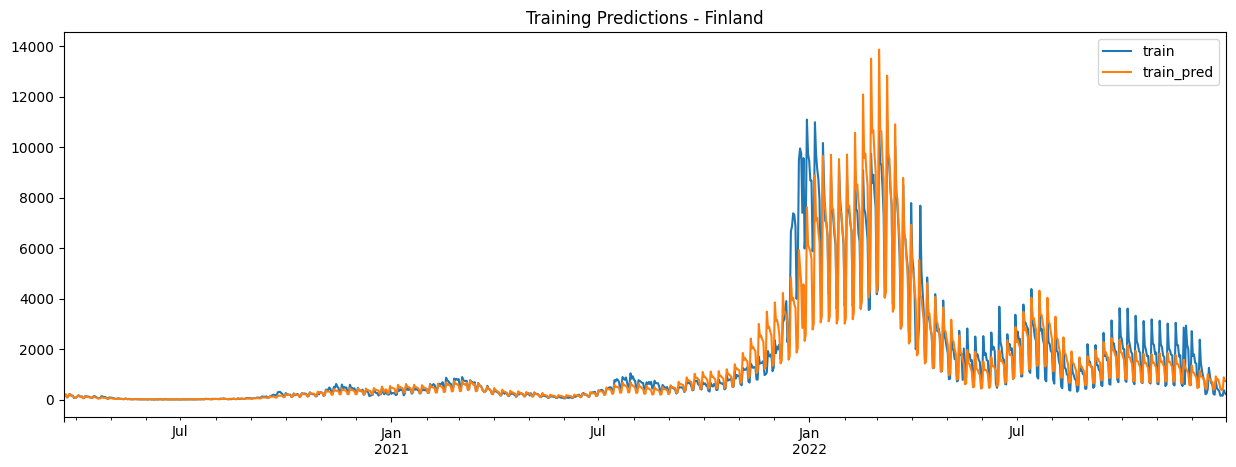

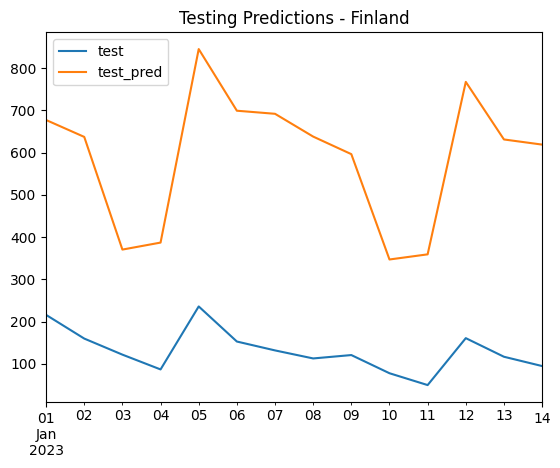

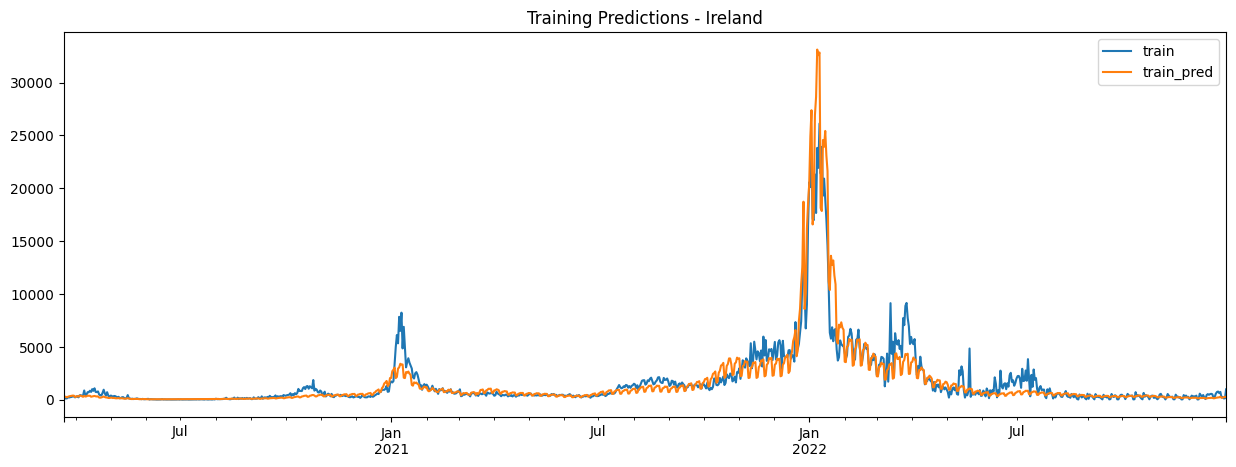

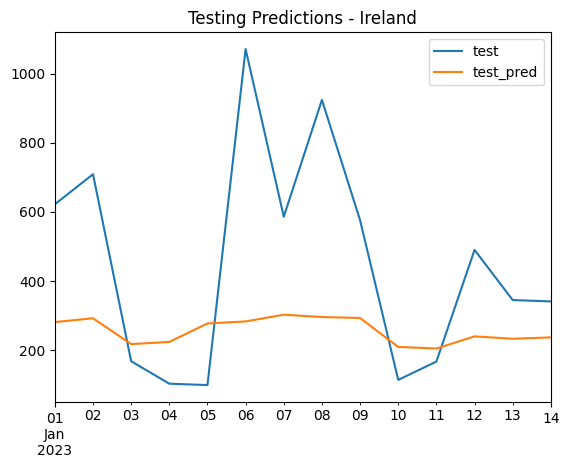

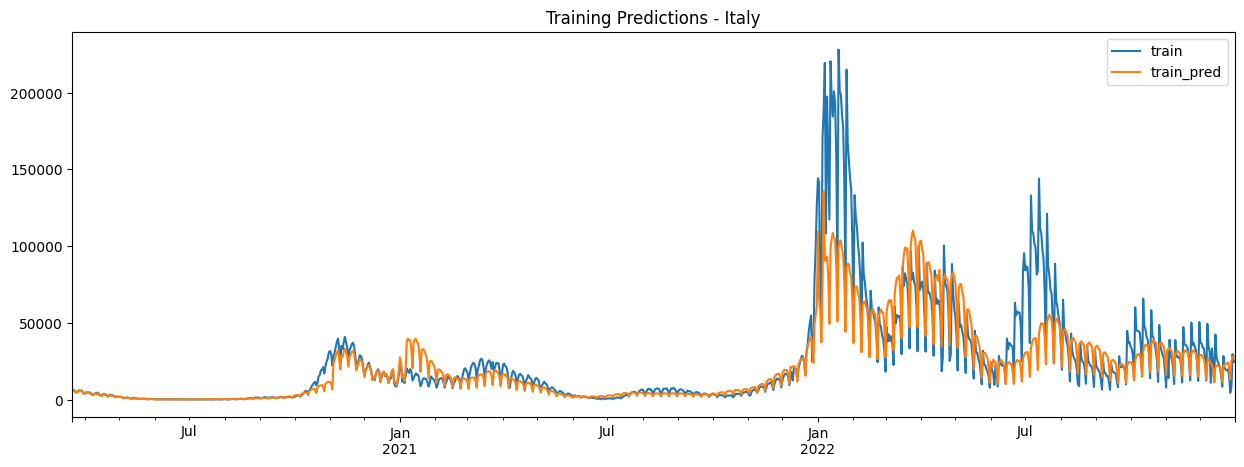

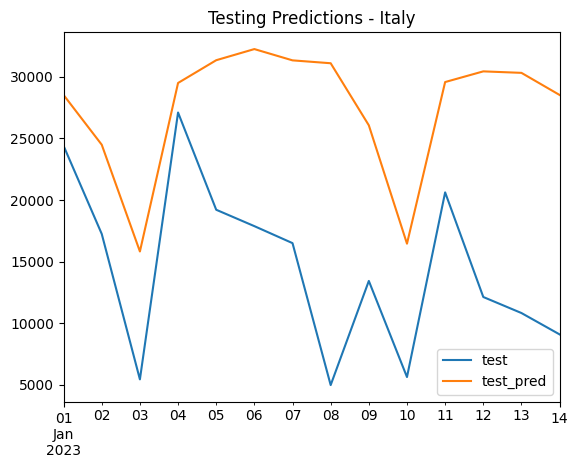

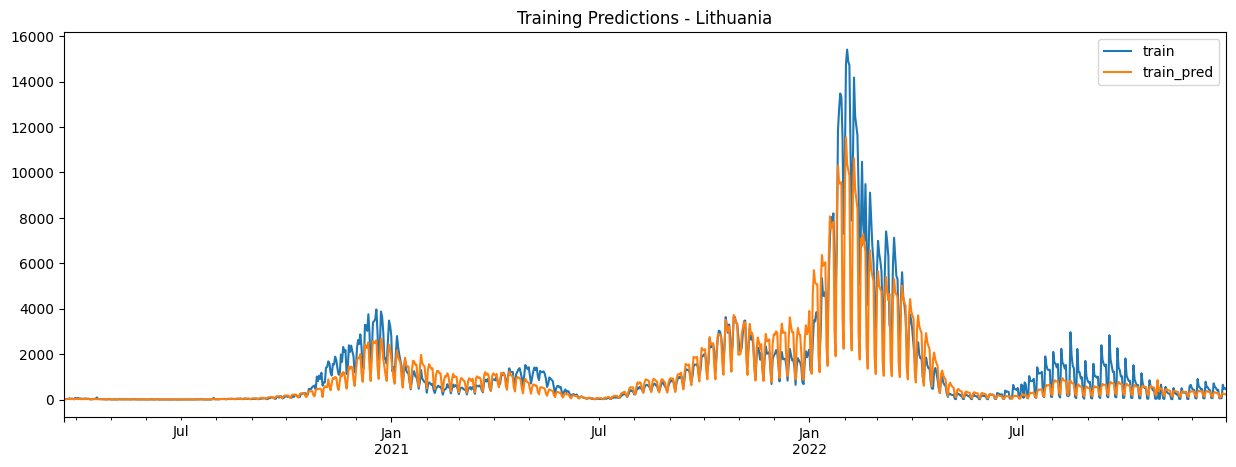

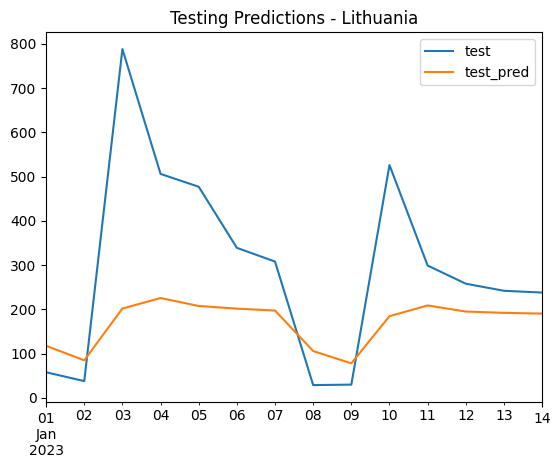

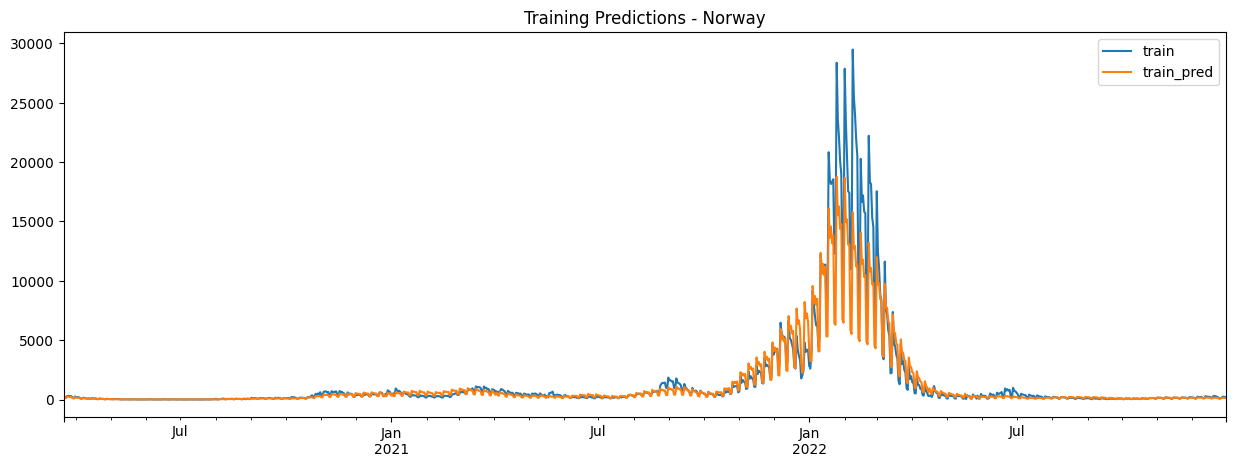

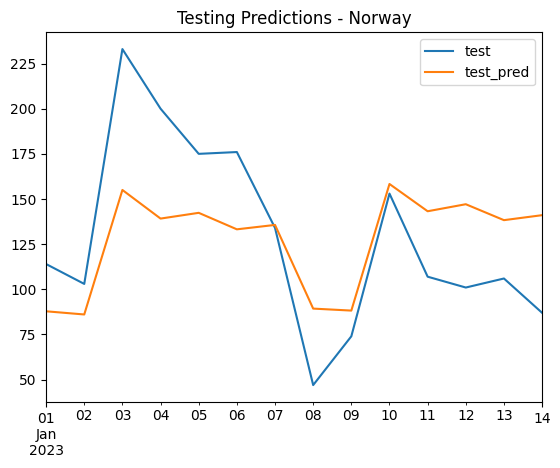

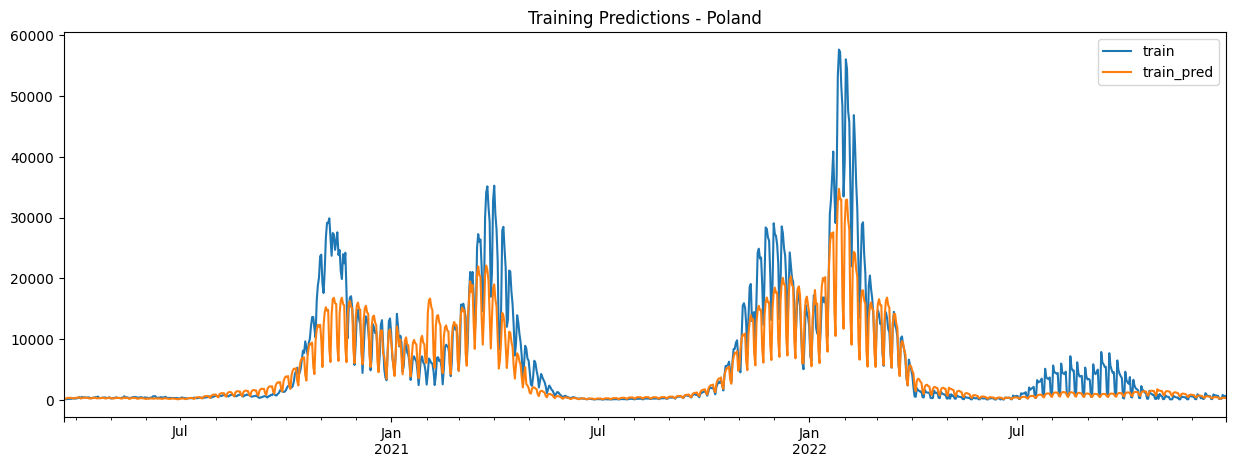

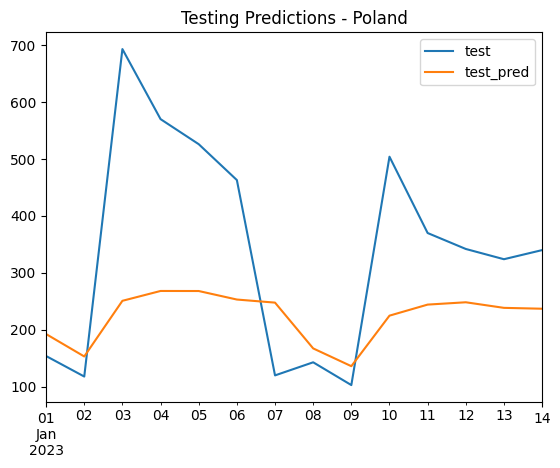

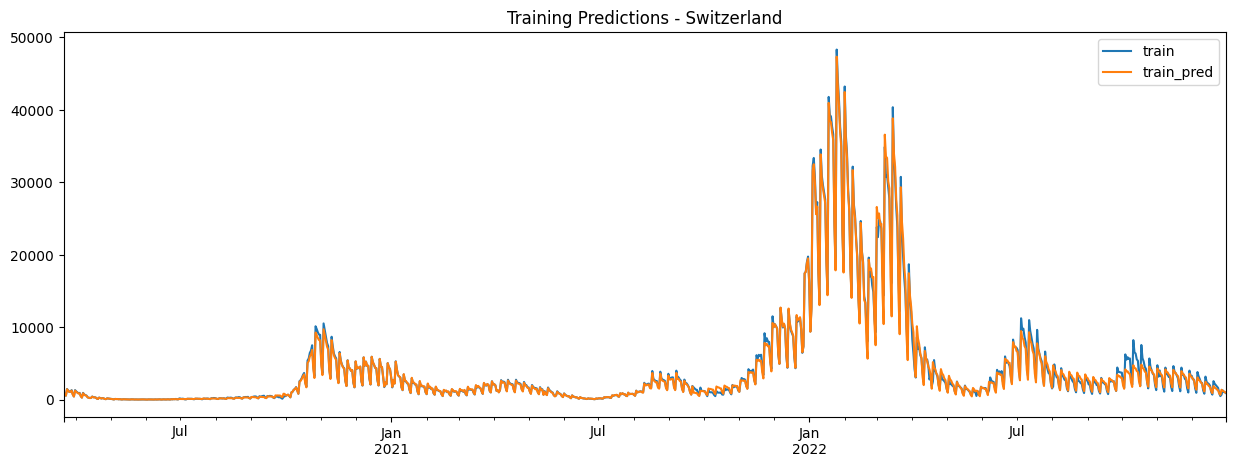

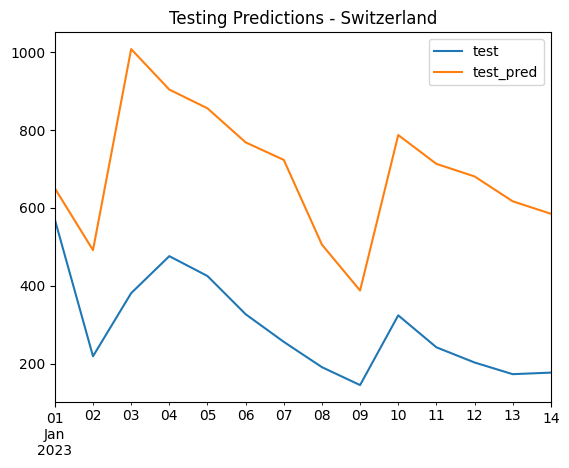

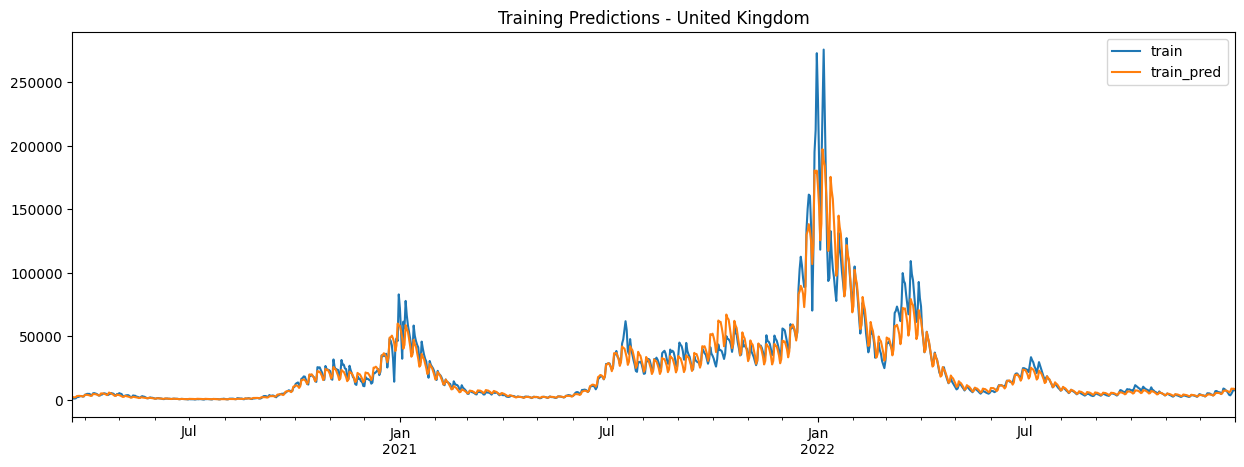

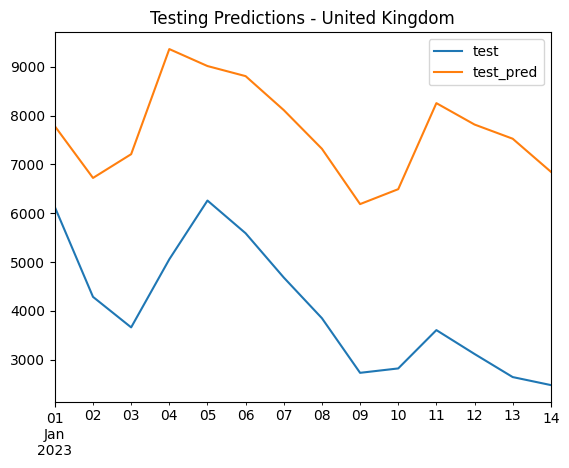

In [8]:
rmse_results = {}
data_clean['date'] = pd.to_datetime(data_clean['date'])
split_date = pd.to_datetime('2023-01-01')

for country in data_clean['location'].unique():
    data_country = data_clean[data_clean['location'] == country]
    data_country = data_country.drop(['location'], axis=1)
    train_country = data_country[data_country['date'] < split_date]
    test_country = data_country[data_country['date'] >= split_date]
    
    country_holidays = globals().get(f'holiday_{country.lower()}')

    # Create and fit the model with the parameters tuned for Italy
    model_country = Prophet(
        holidays=country_holidays,  
        holidays_prior_scale=0.1,
        seasonality_prior_scale=1,
        changepoint_prior_scale=0.05,
        seasonality_mode='multiplicative'
    )
    model_country.fit(train_country.rename(columns={'date': 'ds', 'new_cases_log': 'y'}))

    # training preds
    train_pred = model_country.predict(train_country.reset_index().rename(columns={'date': 'ds', 'new_cases_log': 'y'})).set_index('ds')
    train_pred['yhat_exp'] = np.exp(train_pred['yhat'])
    pd.concat([train_country.set_index('date')['new_cases'],train_pred['yhat_exp']], axis=1).plot(figsize=(15,5)) 
    plt.title(f'Training Predictions - {country}')
    plt.legend(['train', 'train_pred'])

    # tests preds
    test_pred = model_country.predict(test_country.reset_index().rename(columns={'date': 'ds', 'new_cases_log': 'y'})).set_index('ds')
    test_pred['yhat_exp'] = np.exp(test_pred['yhat'])
    pd.concat([test_country.set_index('date')['new_cases'],test_pred['yhat_exp']], axis=1).plot( )
    plt.title(f'Testing Predictions - {country}')
    plt.legend(['test', 'test_pred'])

    # RMSE for training and testing sets
    train_rmse = np.sqrt(mean_squared_error(train_country['new_cases'], train_pred['yhat_exp']))
    test_rmse = np.sqrt(mean_squared_error(test_country['new_cases'], test_pred['yhat_exp']))
    test_srmse = test_rmse / np.mean(test_country['new_cases']) * 100
    rmse_results[country] = {'train_rmse': train_rmse, 'test_rmse': test_rmse, 'test_srmse': test_srmse}
    print(f"{country} - Train RMSE: {train_rmse}, Test RMSE: {test_rmse}, Test SRMSE: {test_srmse}")

rmse_df = pd.DataFrame(rmse_results).T
print(rmse_df)

17:04:03 - cmdstanpy - INFO - Chain [1] start processing
17:04:04 - cmdstanpy - INFO - Chain [1] done processing
17:04:04 - cmdstanpy - INFO - Chain [1] start processing


Belgium - Train RMSE: 1711.7758233906309, Test RMSE: 556.0900421712332, Test SRMSE: 93.90013979492541


17:04:04 - cmdstanpy - INFO - Chain [1] done processing
17:04:05 - cmdstanpy - INFO - Chain [1] start processing


Denmark - Train RMSE: 2496.7725075198778, Test RMSE: 408.55191659851437, Test SRMSE: 69.59151761016183


17:04:05 - cmdstanpy - INFO - Chain [1] done processing
17:04:06 - cmdstanpy - INFO - Chain [1] start processing


Finland - Train RMSE: 627.6668847123697, Test RMSE: 277.5533699734428, Test SRMSE: 211.06720150071695


17:04:06 - cmdstanpy - INFO - Chain [1] done processing
17:04:06 - cmdstanpy - INFO - Chain [1] start processing


Ireland - Train RMSE: 1050.5846557534162, Test RMSE: 279.09297320250283, Test SRMSE: 61.8733432277916


17:04:07 - cmdstanpy - INFO - Chain [1] done processing


Italy - Train RMSE: 14935.357941987048, Test RMSE: 21810.985043022745, Test SRMSE: 149.40054142765084


17:04:08 - cmdstanpy - INFO - Chain [1] start processing
17:04:08 - cmdstanpy - INFO - Chain [1] done processing
17:04:09 - cmdstanpy - INFO - Chain [1] start processing


Lithuania - Train RMSE: 665.1922601161277, Test RMSE: 189.16967450541028, Test SRMSE: 64.03228827552572


17:04:09 - cmdstanpy - INFO - Chain [1] done processing
17:04:09 - cmdstanpy - INFO - Chain [1] start processing


Norway - Train RMSE: 1243.5329316232094, Test RMSE: 138.5509933566079, Test SRMSE: 107.16651419848127


17:04:10 - cmdstanpy - INFO - Chain [1] done processing


Poland - Train RMSE: 3446.5755540938294, Test RMSE: 295.16237845429174, Test SRMSE: 86.6304674708613


17:04:11 - cmdstanpy - INFO - Chain [1] start processing
17:04:13 - cmdstanpy - INFO - Chain [1] done processing
17:04:14 - cmdstanpy - INFO - Chain [1] start processing


Switzerland - Train RMSE: 482.45086660456013, Test RMSE: 322.3488658931079, Test SRMSE: 109.82925584092263


17:04:14 - cmdstanpy - INFO - Chain [1] done processing


United Kingdom - Train RMSE: 8354.00939164358, Test RMSE: 3106.00551528402, Test SRMSE: 76.40312965874175
                  train_rmse     test_rmse  test_srmse
Belgium          1711.775823    556.090042   93.900140
Denmark          2496.772508    408.551917   69.591518
Finland           627.666885    277.553370  211.067202
Ireland          1050.584656    279.092973   61.873343
Italy           14935.357942  21810.985043  149.400541
Lithuania         665.192260    189.169675   64.032288
Norway           1243.532932    138.550993  107.166514
Poland           3446.575554    295.162378   86.630467
Switzerland       482.450867    322.348866  109.829256
United Kingdom   8354.009392   3106.005515   76.403130


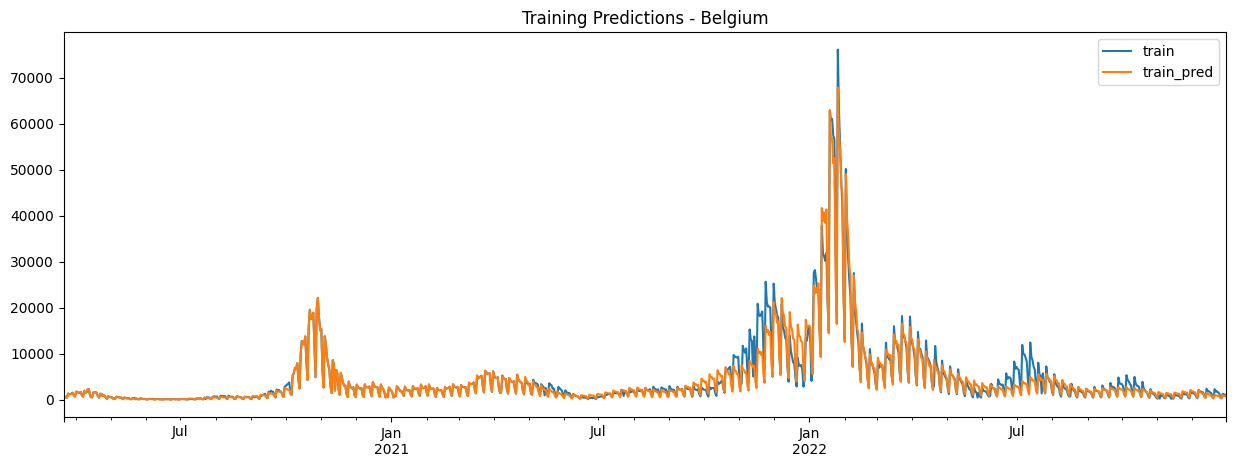

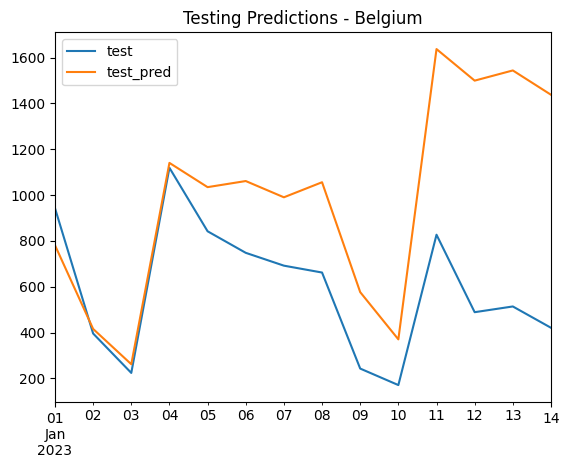

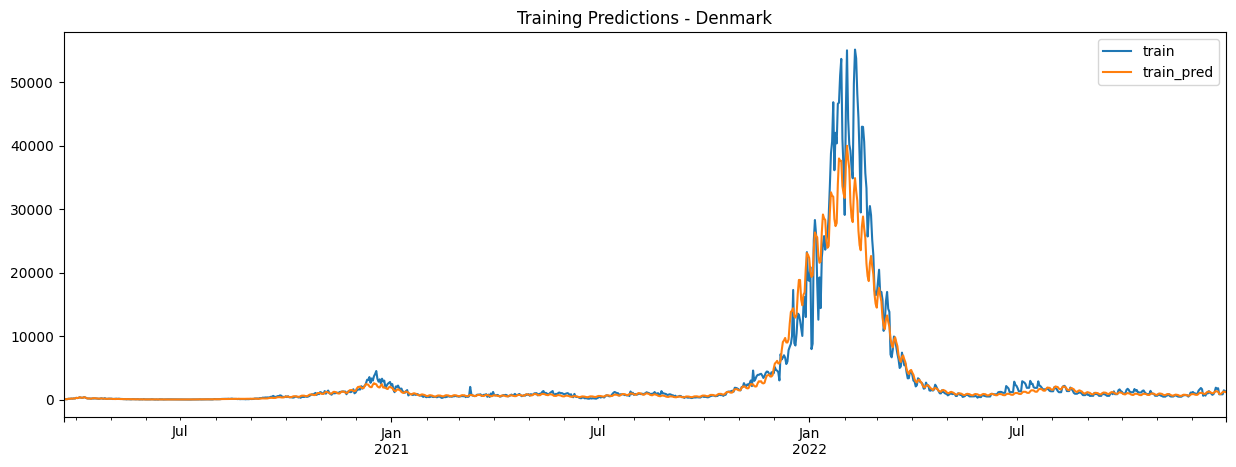

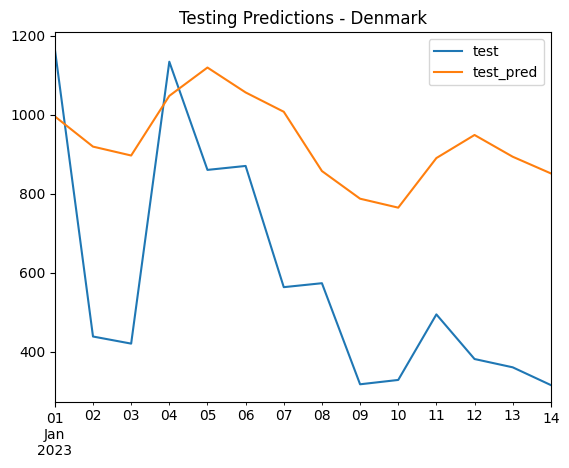

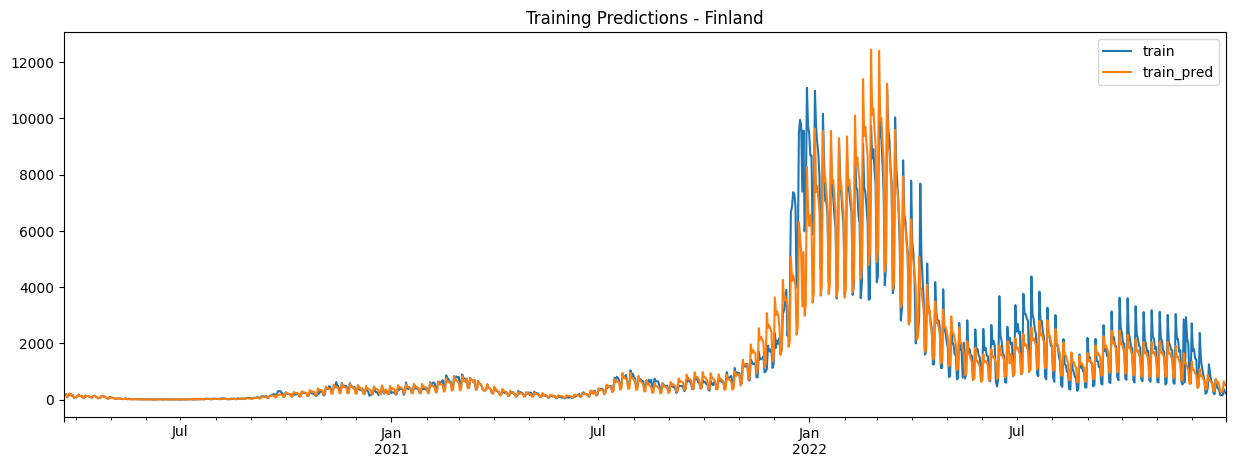

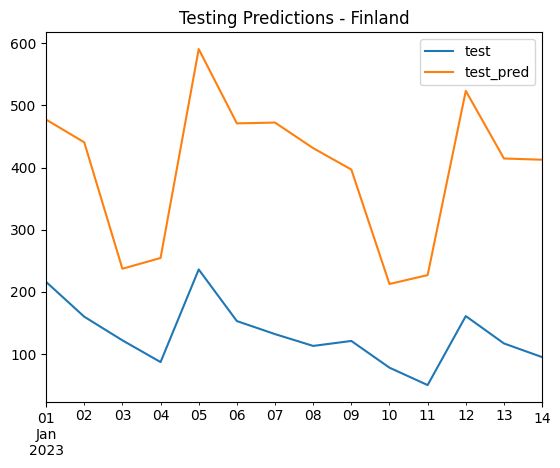

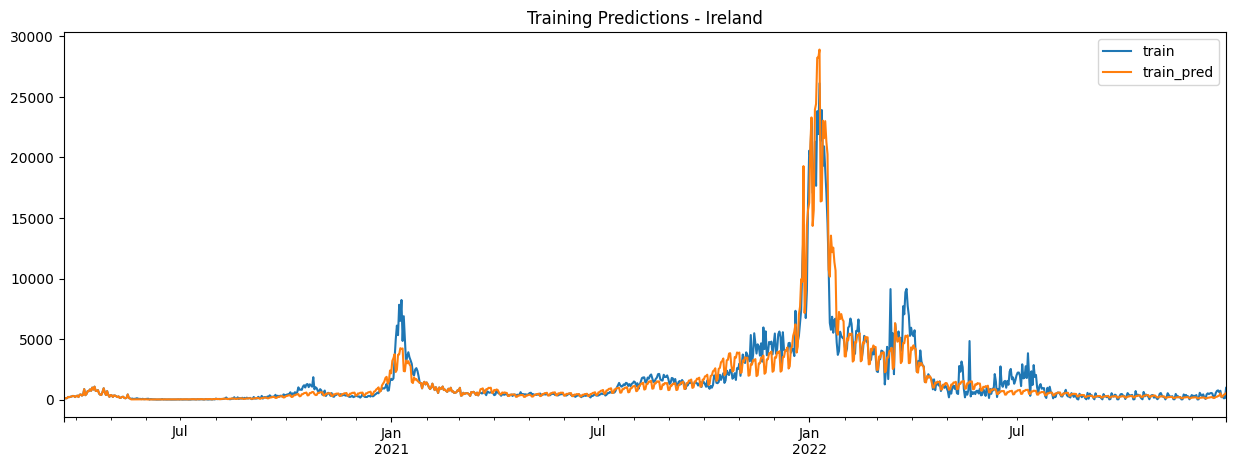

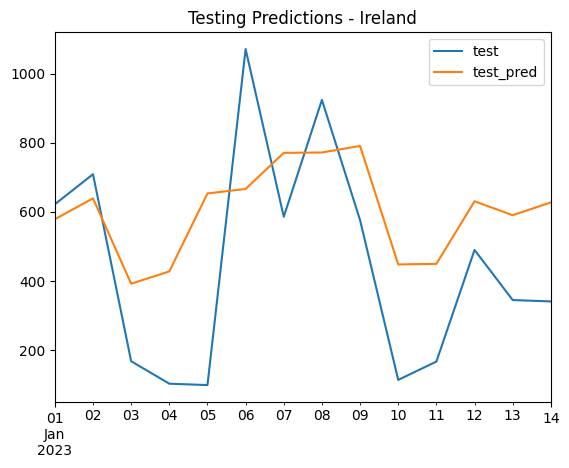

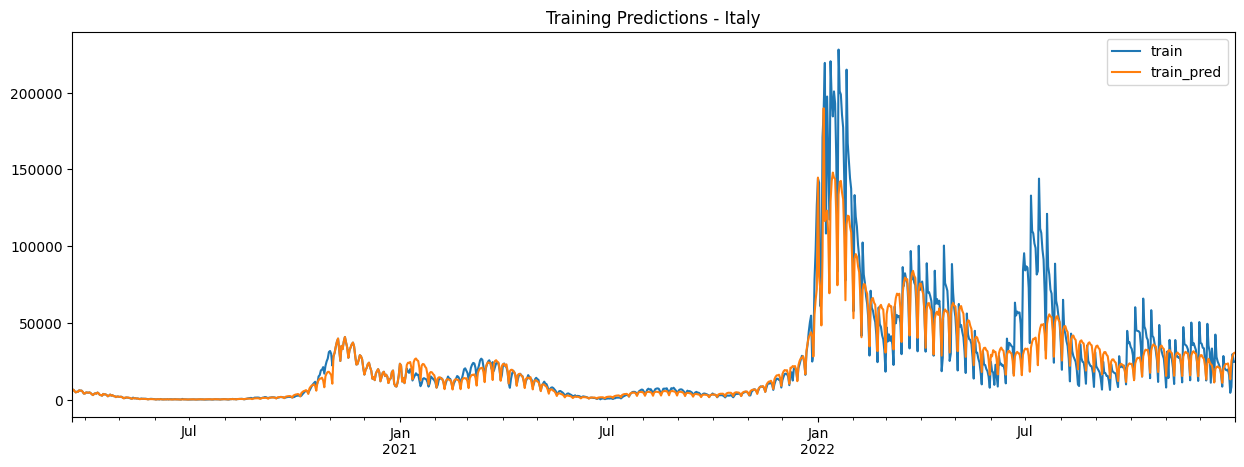

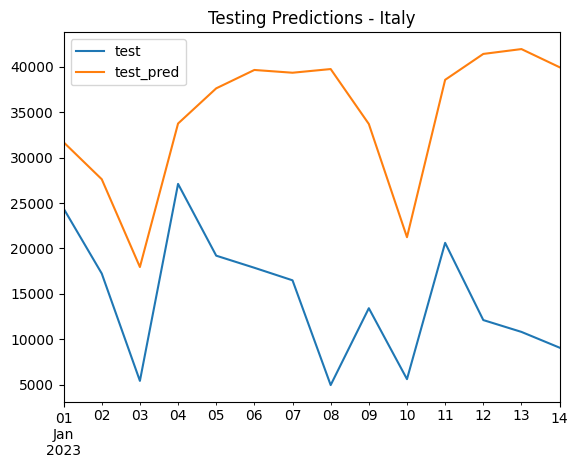

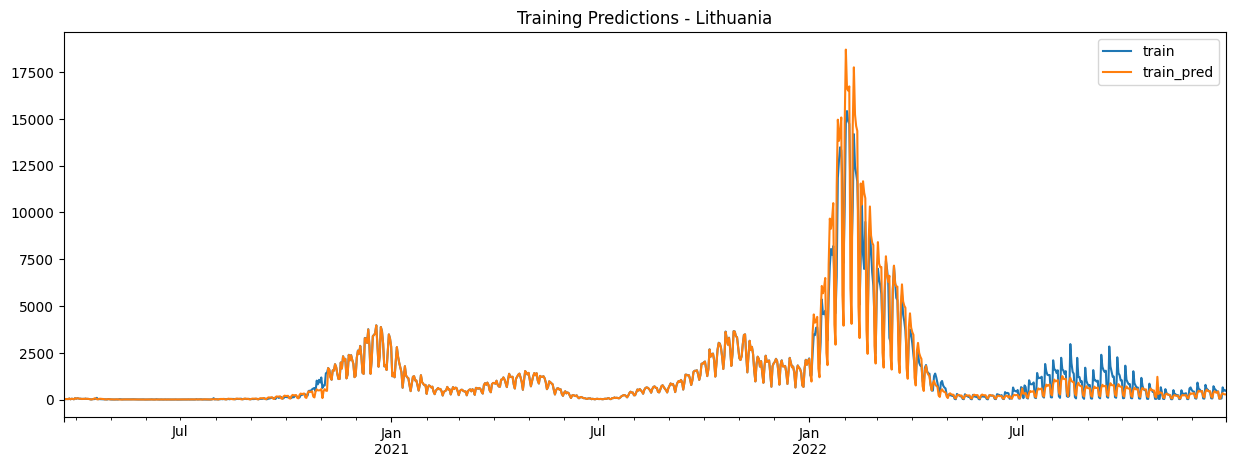

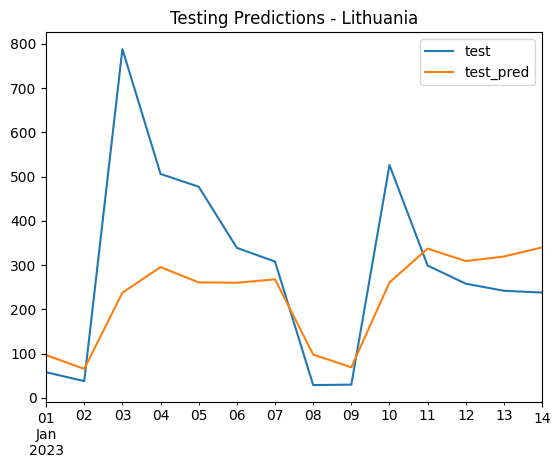

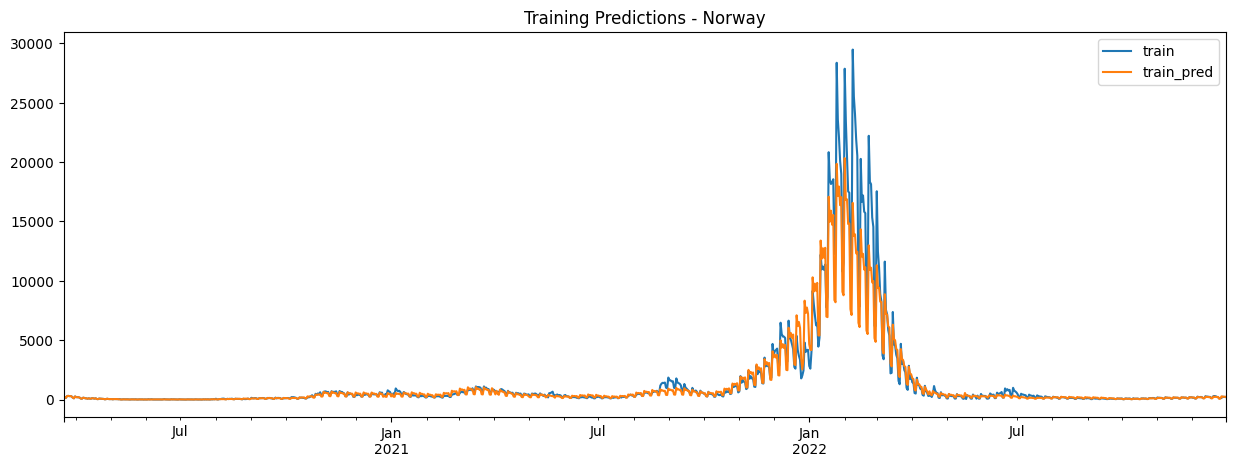

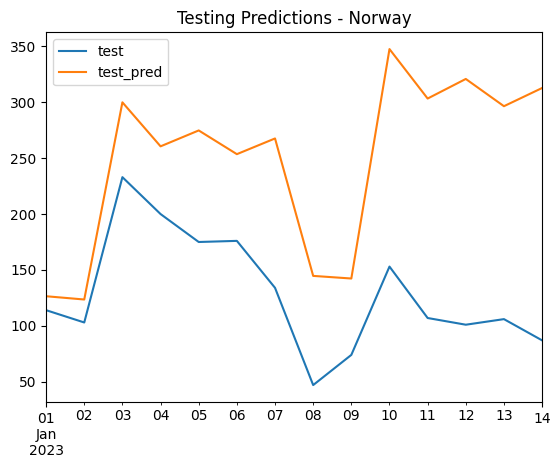

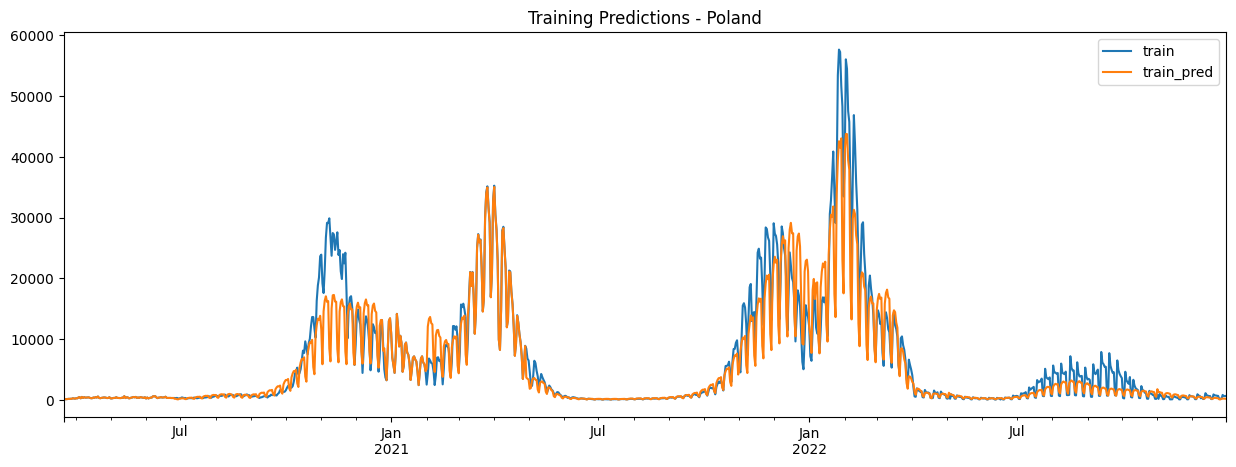

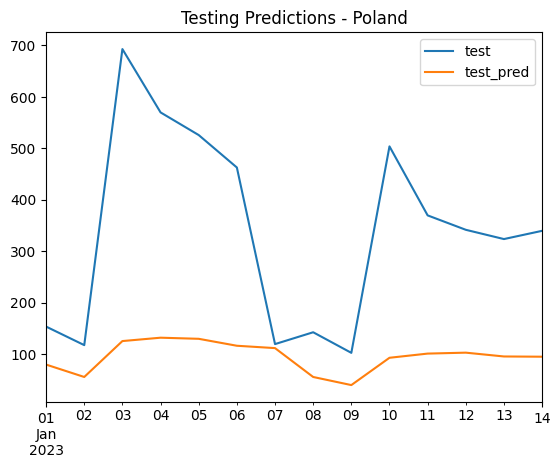

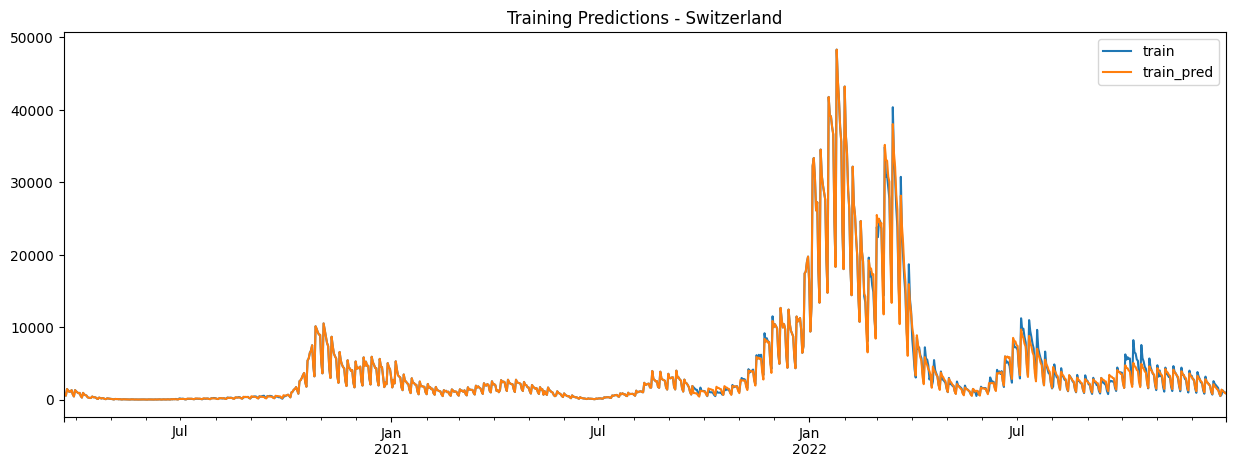

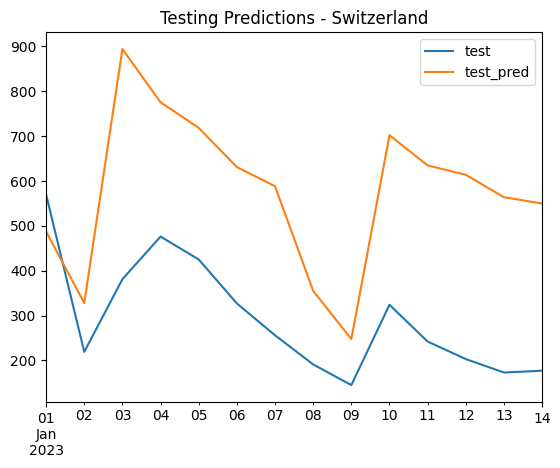

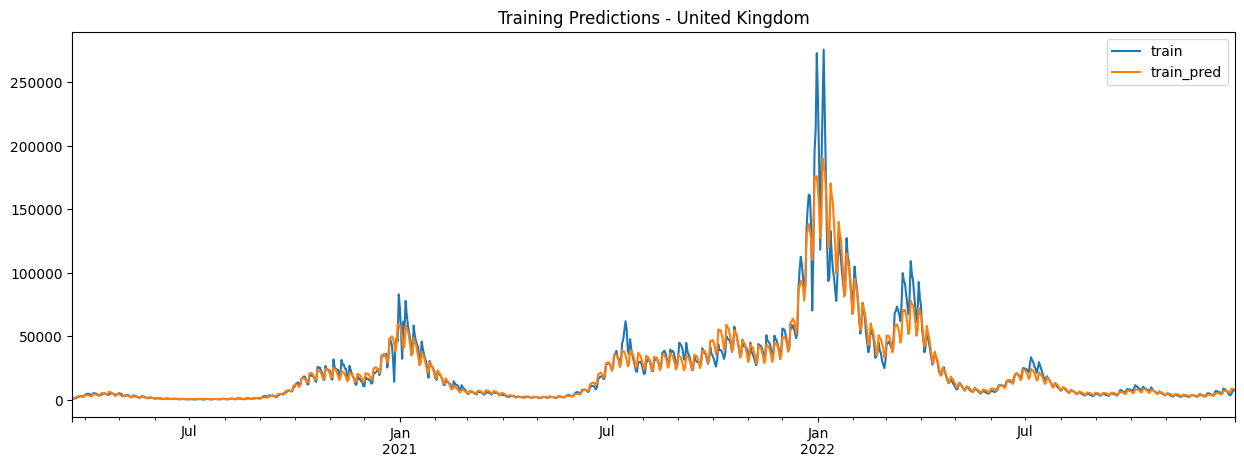

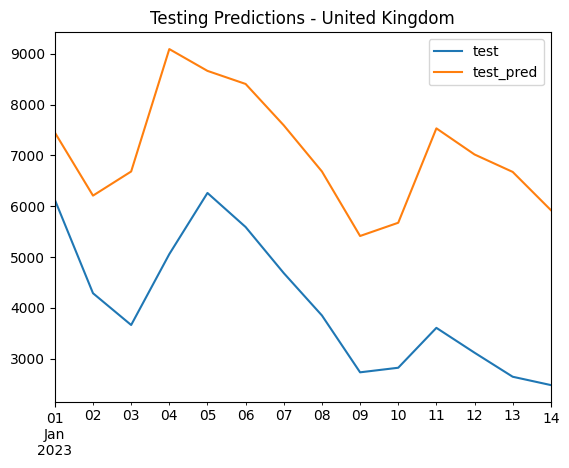

In [10]:
## applying cv results for Italy
rmse_results_cv = {}
data_clean['date'] = pd.to_datetime(data_clean['date'])
split_date = pd.to_datetime('2023-01-01')

for country in data_clean['location'].unique():
    data_country = data_clean[data_clean['location'] == country]
    data_country = data_country.drop(['location'], axis=1)
    train_country = data_country[data_country['date'] < split_date]
    test_country = data_country[data_country['date'] >= split_date]
    
    country_holidays = globals().get(f'holiday_{country.lower()}')

    # Create and fit the model with the parameters tuned for Italy
    model_country = Prophet(
        holidays=country_holidays,  
        holidays_prior_scale=25,
        seasonality_prior_scale=5,
        changepoint_prior_scale=0.1,
        seasonality_mode='additive'
    )
    model_country.fit(train_country.rename(columns={'date': 'ds', 'new_cases_log': 'y'}))

    # training preds
    train_pred = model_country.predict(train_country.reset_index().rename(columns={'date': 'ds', 'new_cases_log': 'y'})).set_index('ds')
    train_pred['yhat_exp'] = np.exp(train_pred['yhat'])
    pd.concat([train_country.set_index('date')['new_cases'],train_pred['yhat_exp']], axis=1).plot(figsize=(15,5)) 
    plt.title(f'Training Predictions - {country}')
    plt.legend(['train', 'train_pred'])

    # tests preds
    test_pred = model_country.predict(test_country.reset_index().rename(columns={'date': 'ds', 'new_cases_log': 'y'})).set_index('ds')
    test_pred['yhat_exp'] = np.exp(test_pred['yhat'])
    pd.concat([test_country.set_index('date')['new_cases'],test_pred['yhat_exp']], axis=1).plot( )
    plt.title(f'Testing Predictions - {country}')
    plt.legend(['test', 'test_pred'])

    # RMSE for training and testing sets
    train_rmse = np.sqrt(mean_squared_error(train_country['new_cases'], train_pred['yhat_exp']))
    test_rmse = np.sqrt(mean_squared_error(test_country['new_cases'], test_pred['yhat_exp']))
    test_srmse = test_rmse / np.mean(test_country['new_cases']) * 100
    rmse_results_cv[country] = {'train_rmse': train_rmse, 'test_rmse': test_rmse, 'test_srmse': test_srmse}
    print(f"{country} - Train RMSE: {train_rmse}, Test RMSE: {test_rmse}, Test SRMSE: {test_srmse}")

rmse_df_cv = pd.DataFrame(rmse_results_cv).T
print(rmse_df_cv)